# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

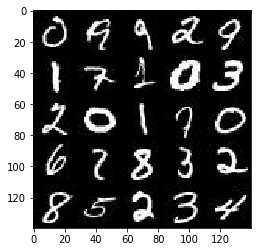

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

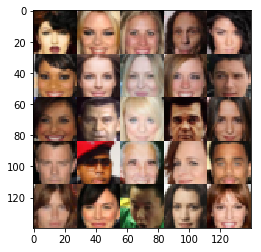

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_input') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, shape=None, name="learning_rate")    
    return (inputs_real, inputs_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        relu3_shape = relu3.get_shape().as_list()
        

        # Flatten it
        flat = tf.reshape(relu3, (-1, relu3_shape[1]*relu3_shape[2]*relu3_shape[3]))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
                
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})


                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0021... Generator Loss: 17.2060
Epoch 1/2... Discriminator Loss: 3.2652... Generator Loss: 4.0759
Epoch 1/2... Discriminator Loss: 2.7929... Generator Loss: 1.9084
Epoch 1/2... Discriminator Loss: 2.5110... Generator Loss: 1.8733
Epoch 1/2... Discriminator Loss: 2.2298... Generator Loss: 2.2226
Epoch 1/2... Discriminator Loss: 1.9519... Generator Loss: 2.0788
Epoch 1/2... Discriminator Loss: 1.8076... Generator Loss: 2.1325
Epoch 1/2... Discriminator Loss: 1.6902... Generator Loss: 2.0630
Epoch 1/2... Discriminator Loss: 1.6932... Generator Loss: 2.2609
Epoch 1/2... Discriminator Loss: 1.7906... Generator Loss: 3.1635


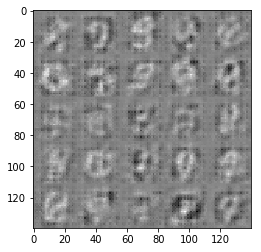

Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 2.6312
Epoch 1/2... Discriminator Loss: 0.5226... Generator Loss: 1.4828
Epoch 1/2... Discriminator Loss: 0.0965... Generator Loss: 2.6550
Epoch 1/2... Discriminator Loss: 0.0632... Generator Loss: 3.0810
Epoch 1/2... Discriminator Loss: 0.0564... Generator Loss: 3.9720
Epoch 1/2... Discriminator Loss: 2.2273... Generator Loss: 0.1645
Epoch 1/2... Discriminator Loss: 1.8390... Generator Loss: 0.2253
Epoch 1/2... Discriminator Loss: 1.6257... Generator Loss: 0.2776
Epoch 1/2... Discriminator Loss: 1.6093... Generator Loss: 0.2890
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.3694


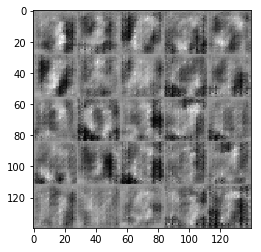

Epoch 1/2... Discriminator Loss: 1.2799... Generator Loss: 0.3820
Epoch 1/2... Discriminator Loss: 2.1720... Generator Loss: 0.1294
Epoch 1/2... Discriminator Loss: 1.9667... Generator Loss: 0.1690
Epoch 1/2... Discriminator Loss: 0.5219... Generator Loss: 1.2697
Epoch 1/2... Discriminator Loss: 0.4804... Generator Loss: 1.2713
Epoch 1/2... Discriminator Loss: 1.2299... Generator Loss: 0.4399
Epoch 1/2... Discriminator Loss: 0.1967... Generator Loss: 2.1218
Epoch 1/2... Discriminator Loss: 0.1880... Generator Loss: 2.1543
Epoch 1/2... Discriminator Loss: 0.2190... Generator Loss: 2.0981
Epoch 1/2... Discriminator Loss: 1.5764... Generator Loss: 2.9387


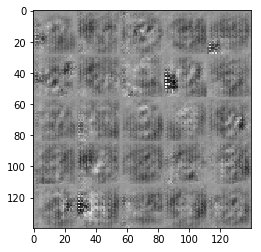

Epoch 1/2... Discriminator Loss: 2.1352... Generator Loss: 2.4657
Epoch 1/2... Discriminator Loss: 1.7571... Generator Loss: 2.0750
Epoch 1/2... Discriminator Loss: 0.6453... Generator Loss: 2.1141
Epoch 1/2... Discriminator Loss: 1.7414... Generator Loss: 2.7946
Epoch 1/2... Discriminator Loss: 2.1060... Generator Loss: 0.1545
Epoch 1/2... Discriminator Loss: 0.8008... Generator Loss: 1.3884
Epoch 1/2... Discriminator Loss: 0.4259... Generator Loss: 1.3870
Epoch 1/2... Discriminator Loss: 1.8744... Generator Loss: 5.4067
Epoch 1/2... Discriminator Loss: 1.3756... Generator Loss: 1.2970
Epoch 1/2... Discriminator Loss: 1.5660... Generator Loss: 2.0510


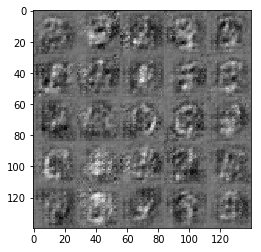

Epoch 1/2... Discriminator Loss: 1.7370... Generator Loss: 1.6883
Epoch 1/2... Discriminator Loss: 0.8591... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 1.7832... Generator Loss: 2.4726
Epoch 1/2... Discriminator Loss: 0.4426... Generator Loss: 1.3080
Epoch 1/2... Discriminator Loss: 0.6638... Generator Loss: 0.8857
Epoch 1/2... Discriminator Loss: 1.5114... Generator Loss: 0.3120
Epoch 2/2... Discriminator Loss: 0.1016... Generator Loss: 3.3555
Epoch 2/2... Discriminator Loss: 2.1172... Generator Loss: 4.4701
Epoch 2/2... Discriminator Loss: 1.8243... Generator Loss: 1.9305
Epoch 2/2... Discriminator Loss: 0.7292... Generator Loss: 1.8820


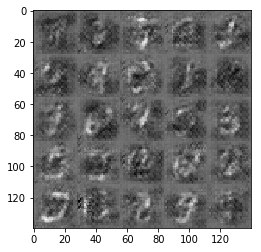

Epoch 2/2... Discriminator Loss: 0.2326... Generator Loss: 1.8220
Epoch 2/2... Discriminator Loss: 0.2075... Generator Loss: 2.1963
Epoch 2/2... Discriminator Loss: 1.8847... Generator Loss: 0.2246
Epoch 2/2... Discriminator Loss: 0.1649... Generator Loss: 3.1262
Epoch 2/2... Discriminator Loss: 3.1824... Generator Loss: 0.0541
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.3446
Epoch 2/2... Discriminator Loss: 0.2878... Generator Loss: 4.0465
Epoch 2/2... Discriminator Loss: 0.0837... Generator Loss: 3.8616
Epoch 2/2... Discriminator Loss: 0.0650... Generator Loss: 3.7177
Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.5132


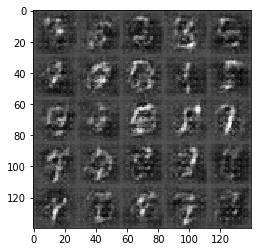

Epoch 2/2... Discriminator Loss: 2.0164... Generator Loss: 0.1734
Epoch 2/2... Discriminator Loss: 1.7896... Generator Loss: 0.2202
Epoch 2/2... Discriminator Loss: 1.7529... Generator Loss: 0.2304
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 0.4922
Epoch 2/2... Discriminator Loss: 1.0727... Generator Loss: 0.5673
Epoch 2/2... Discriminator Loss: 1.2944... Generator Loss: 1.7601
Epoch 2/2... Discriminator Loss: 0.9321... Generator Loss: 1.6576
Epoch 2/2... Discriminator Loss: 1.0906... Generator Loss: 2.5766
Epoch 2/2... Discriminator Loss: 0.1852... Generator Loss: 2.4014
Epoch 2/2... Discriminator Loss: 0.1849... Generator Loss: 2.9215


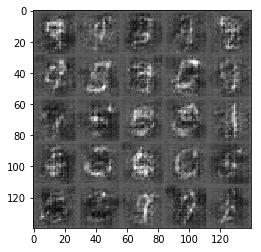

Epoch 2/2... Discriminator Loss: 0.0714... Generator Loss: 3.4250
Epoch 2/2... Discriminator Loss: 0.2292... Generator Loss: 1.8657
Epoch 2/2... Discriminator Loss: 0.0393... Generator Loss: 4.1983
Epoch 2/2... Discriminator Loss: 1.1310... Generator Loss: 0.6008
Epoch 2/2... Discriminator Loss: 0.5117... Generator Loss: 1.1621
Epoch 2/2... Discriminator Loss: 0.0533... Generator Loss: 4.0282
Epoch 2/2... Discriminator Loss: 0.9256... Generator Loss: 1.4461
Epoch 2/2... Discriminator Loss: 1.1029... Generator Loss: 2.2924
Epoch 2/2... Discriminator Loss: 0.4188... Generator Loss: 2.2532
Epoch 2/2... Discriminator Loss: 2.5454... Generator Loss: 3.2845


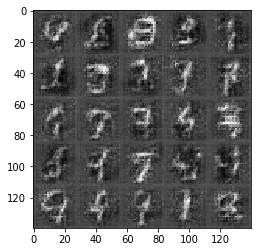

Epoch 2/2... Discriminator Loss: 0.7432... Generator Loss: 2.3298
Epoch 2/2... Discriminator Loss: 0.3200... Generator Loss: 1.5499
Epoch 2/2... Discriminator Loss: 0.0790... Generator Loss: 3.4119
Epoch 2/2... Discriminator Loss: 0.0529... Generator Loss: 3.7132
Epoch 2/2... Discriminator Loss: 0.0397... Generator Loss: 4.1865
Epoch 2/2... Discriminator Loss: 0.0257... Generator Loss: 5.0518
Epoch 2/2... Discriminator Loss: 0.1771... Generator Loss: 2.0722
Epoch 2/2... Discriminator Loss: 0.0347... Generator Loss: 3.9153
Epoch 2/2... Discriminator Loss: 0.0129... Generator Loss: 6.4906
Epoch 2/2... Discriminator Loss: 0.0169... Generator Loss: 4.9043


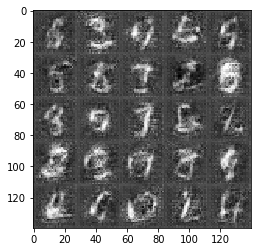

Epoch 2/2... Discriminator Loss: 0.0154... Generator Loss: 5.6415
Epoch 2/2... Discriminator Loss: 0.0925... Generator Loss: 2.7306
Epoch 2/2... Discriminator Loss: 0.0185... Generator Loss: 4.6859


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4767... Generator Loss: 2.7146
Epoch 1/1... Discriminator Loss: 1.9117... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 1.4037
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.3451
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 2.2612
Epoch 1/1... Discriminator Loss: 0.0370... Generator Loss: 4.2869
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 5.7351
Epoch 1/1... Discriminator Loss: 0.0715... Generator Loss: 3.0945
Epoch 1/1... Discriminator Loss: 0.0122... Generator Loss: 5.6385
Epoch 1/1... Discriminator Loss: 0.0749... Generator Loss: 2.9030


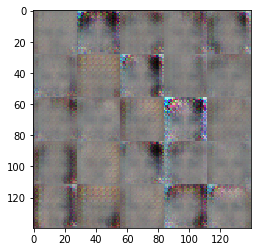

Epoch 1/1... Discriminator Loss: 1.5736... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 2.7131... Generator Loss: 2.6931
Epoch 1/1... Discriminator Loss: 0.0661... Generator Loss: 3.3115
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.4549
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 1.0615


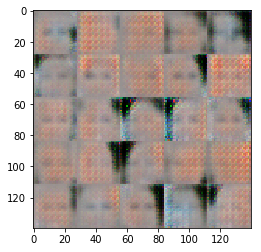

Epoch 1/1... Discriminator Loss: 0.0984... Generator Loss: 2.5606
Epoch 1/1... Discriminator Loss: 0.0724... Generator Loss: 3.0211
Epoch 1/1... Discriminator Loss: 0.0236... Generator Loss: 4.4024
Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 6.2348
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 1.2786
Epoch 1/1... Discriminator Loss: 5.1953... Generator Loss: 5.9032
Epoch 1/1... Discriminator Loss: 0.2717... Generator Loss: 3.1278
Epoch 1/1... Discriminator Loss: 0.5004... Generator Loss: 3.9584
Epoch 1/1... Discriminator Loss: 0.1103... Generator Loss: 2.6349
Epoch 1/1... Discriminator Loss: 0.1235... Generator Loss: 2.5820


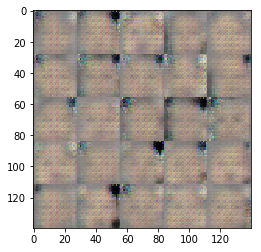

Epoch 1/1... Discriminator Loss: 3.8802... Generator Loss: 3.2430
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 1.0552
Epoch 1/1... Discriminator Loss: 0.0658... Generator Loss: 3.1658
Epoch 1/1... Discriminator Loss: 0.0247... Generator Loss: 4.2184
Epoch 1/1... Discriminator Loss: 0.0384... Generator Loss: 3.7045
Epoch 1/1... Discriminator Loss: 0.0205... Generator Loss: 4.3815
Epoch 1/1... Discriminator Loss: 0.0133... Generator Loss: 4.9431
Epoch 1/1... Discriminator Loss: 0.0280... Generator Loss: 4.1190
Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 5.2198
Epoch 1/1... Discriminator Loss: 0.1237... Generator Loss: 3.0740


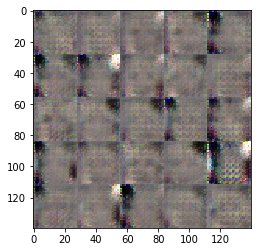

Epoch 1/1... Discriminator Loss: 2.8391... Generator Loss: 0.1017
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.5999... Generator Loss: 0.3373
Epoch 1/1... Discriminator Loss: 1.6976... Generator Loss: 0.2981
Epoch 1/1... Discriminator Loss: 1.6125... Generator Loss: 0.3091
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.3943
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.4157
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.3153
Epoch 1/1... Discriminator Loss: 1.6596... Generator Loss: 0.5006
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.9149


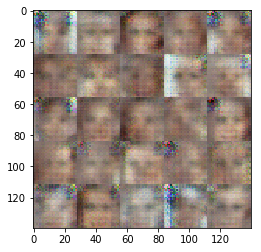

Epoch 1/1... Discriminator Loss: 2.6587... Generator Loss: 2.0508
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 1.2100
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.7556


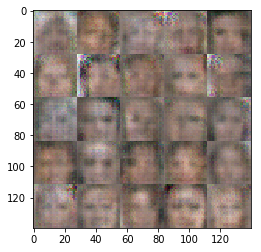

Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 1.1540
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.5130


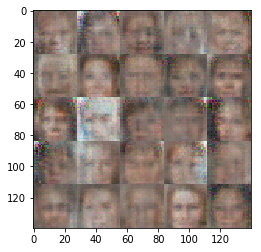

Epoch 1/1... Discriminator Loss: 1.6004... Generator Loss: 0.3541
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.4738
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.4270
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 1.0532
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7546


In [17]:
batch_size = 256
z_dim = 300
learning_rate = 0.002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.